In [2]:
%pylab inline

import os, glob, sys, time, datetime
import pandas as pd
import pandas.io.sql as pdsql
from pandas import DataFrame, Series
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array
import scipy as sp
from scipy import stats
from scipy.stats import norm

import talib as ta
from talib import MA_Type

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.font_manager as font_manager
import seaborn as sns

#맑은고딕체
sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

#나눔고딕체
# sns.set(style="whitegrid", font="NanumGothic", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NanumGothic.TTF", size=15)

#새굴림체
# sns.set(style="whitegrid", font="New Gulim", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NGULIM.TTF", size=15)

def comma_volume(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}K'.format(int(x/1000))
    return s

def comma_price(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s

def comma_percent(x, pos):  # formatter function takes tick label and tick position
    s = '{:+.2f}'.format(x)
    return s

major_date_formatter = dates.DateFormatter('%Y-%m-%d')
minor_date_formatter = dates.DateFormatter('%m')
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)

sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def XGBoost_Feature(model, df, X_columns, y_columns, performCV=True, printFeatureImportance=True, cv_folds=5):
    print(model)

    model.fit(df[X_columns], df[y_columns])
        
    df_predictions = model.predict(df[X_columns])
    try:
        df_predprob = model.predict_proba(df[X_columns])[:,1]
    except Exception as e:
        pass

    print ("\n모델 보고서")
    try:
        print ("정확도(Accuracy) : %.4g" % metrics.accuracy_score(df[y_columns].values, df_predictions))
    except Exception as e:
        pass

    try:
        print ("AUC 점수 (Train): %f" % metrics.roc_auc_score(df[y_columns].values, df_predprob))
    except Exception as e:
        pass

    if performCV:
        try:
            cv_score = cross_validation.cross_val_score(model, df[X_columns], df[y_columns], cv=cv_folds, scoring='roc_auc')
            print ("교차검증(CV) 점수 : 평균 - %.7g | 표준편차 - %.7g | 최소값 - %.7g | 최대값 - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        except Exception as e:
            pass
        
    try:
        if printFeatureImportance:
            fig, ax = plt.subplots(1, 1, sharex=True)
            feat_imp = pd.Series(model.feature_importances_, X_columns).sort_values(ascending=False)
            feat_imp.plot(ax=ax, kind='bar', title='특성(Feature) 중요도')
            ax.yaxis.set_major_formatter(percent_formatter)
            plt.ylabel('특성(Feature) 중요도 점수')
            plt.savefig('특성(Feature) 중요도.png')
            plt.show()
    except Exception as e:
        pass

def XGBoost_TuningTest(model, X, y, param_grid=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

---

* 모멘텀과 주가 위치를 활용 *

In [5]:
df = pd.read_csv('kodex200.csv', encoding='cp949')
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True)
df.set_index('일시', inplace=True)
df.drop(['index'], axis=1, inplace=True)

df.tail()

,시가,고가,저가,종가
일시,,,,
2018-07-11,29515,29635,29280,29560
2018-07-12,29615,29800,29500,29650
2018-07-13,29695,30040,29685,29945
2018-07-16,29975,30050,29825,29855
2018-07-17,29860,29925,29680,29820


In [7]:
X_COLUMNS = []

for i in range(1,6):
    df['R%d' % i] = (df['종가']-df['종가'].shift(i)) / df['종가'].shift(i)
    X_COLUMNS.append('R%d' % i)
    
for i in range(1,6):
    df['P%d' % i] = (df['종가'] - df['종가'].rolling(window=5).min().shift(i)) / (df['종가'].rolling(window=5).max().shift(i) - df['종가'].rolling(window=5).min().shift(i))
    X_COLUMNS.append('P%d' % i)
    
# df['수익률'] = (df['고가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['수익률'] = (df['종가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['y'] = df['수익률'].apply(lambda x: 1 if x > 0.003 else 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.tail()    

,시가,고가,저가,종가,R1,R2,R3,R4,R5,P1,P2,P3,P4,P5,수익률,y
일시,,,,,,,,,,,,,,,,
2018-07-09,29460,29785,29375,29690,0.007465,0.014696,0.012274,0.009349,0.010723,2.047619,0.547771,0.503497,0.360000,0.319797,-0.002684,0
2018-07-10,29810,29905,29710,29730,0.001347,0.008823,0.016063,0.013638,0.010709,1.093023,2.238095,0.598726,0.559441,0.405714,0.001525,0
2018-07-11,29515,29635,29280,29560,-0.005718,-0.004379,0.003054,0.010253,0.007842,0.638298,0.697674,1.428571,0.382166,0.321678,0.001182,0
2018-07-12,29615,29800,29500,29650,0.003045,-0.002691,-0.001347,0.006108,0.013329,0.829787,0.829787,0.906977,1.857143,0.496815,0.008419,1
2018-07-13,29695,30040,29685,29945,0.009949,0.013024,0.007232,0.008589,0.016118,1.826923,1.457447,1.457447,1.593023,3.261905,-0.004003,0


In [8]:
X_COLUMNS

['R1', 'R2', 'R3', 'R4', 'R5', 'P1', 'P2', 'P3', 'P4', 'P5']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델 보고서
정확도(Accuracy) : 0.6909
AUC 점수 (Train): 0.761547
교차검증(CV) 점수 : 평균 - 0.5371155 | 표준편차 - 0.03937689 | 최소값 - 0.4668863 | 최대값 - 0.5864711


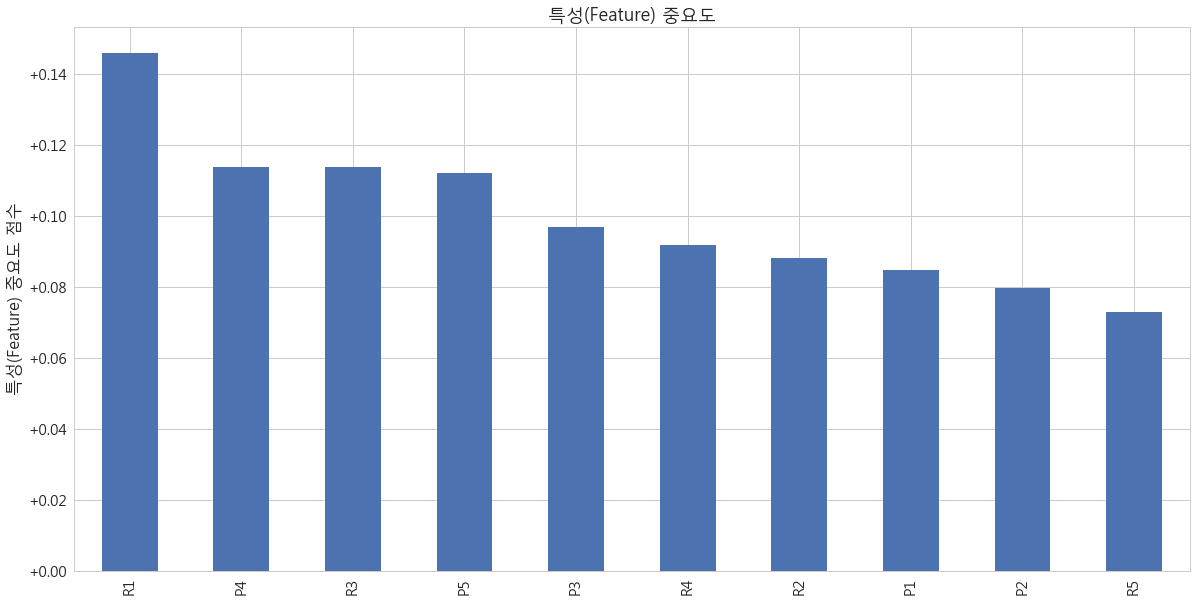

In [9]:
X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

---

* ZigZag 응용 *
- HTS 에서 ZigZag 데이타를 받는다.

In [11]:
# df = pd.read_csv('kodex 200-zigzag.csv', header=[0], encoding='cp949')
df = pd.read_csv('kodex 200-zigzag.csv', encoding='cp949')
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True)
df.set_index('일시', inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.tail()

,시가,고가,저가,종가,대비,대비율,ZigZag,거래량
일시,,,,,,,,
2018-07-03,29540,29595,29200,29415,▲40,0.14%,29922,9888905
2018-07-04,29430,29560,29305,29330,▼85,-0.29%,29864,7033754
2018-07-05,29330,29465,29090,29260,▼70,-0.24%,29806,7924009
2018-07-06,29250,29605,29130,29470,▲210,0.72%,29748,9005217
2018-07-09,29460,29785,29375,29690,▲220,0.75%,29690,8414750


In [12]:
df['TREND'] = np.sign(df['ZigZag']-df['ZigZag'].shift(1))
df.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in sign
  if __name__ == '__main__':


,시가,고가,저가,종가,대비,대비율,ZigZag,거래량,TREND
일시,,,,,,,,,
2002-10-14,5930,6082,5771,5892,0,0.00%,5892,2577230,NaN
2002-10-15,5968,6067,5854,6037,▲144,2.45%,5926,2288769,1.0
2002-10-16,6113,6113,6014,6059,▲23,0.38%,5960,2039150,1.0
2002-10-17,6067,6219,5983,6143,▲84,1.38%,5994,2091777,1.0
2002-10-18,6310,6462,6272,6409,▲266,4.33%,6027,1321300,1.0


In [13]:
X_COLUMNS = []

for i in [2,3,5,10,20,40,60,90,120,240]:
    df['EMA%03d' % i] = ta.EMA(np.array(df['종가'].astype(float)), timeperiod=i)
    df['이격도%03d' % i] = (df['종가'] - df['EMA%03d' % i]) / df['EMA%03d' % i]
    X_COLUMNS.append('이격도%03d' % i)

for i in [20, 60, 240]:
    df['Bup'], df['Bctr'], df['Bdown'] = ta.BBANDS(np.array(df['종가'].astype(float)), timeperiod=i, nbdevup=2.0, nbdevdn=2.0, matype=ta.MA_Type.EMA)
    df['pB%03d' % i] = (df['종가'] - df['Bdown']) / (df['Bup'] - df['Bdown'])
    X_COLUMNS.append('pB%03d' % i)

for i in [3,5,7,10,14]:
    df['RSI%02d' % i] = ta.RSI(np.array(df['종가'].astype(float)), timeperiod=i) / 100
    X_COLUMNS.append('RSI%02d' % i)

for i in range(1,6):
    df['R%d' % i] = (df['종가']-df['종가'].shift(i)) / df['종가'].shift(i)
    X_COLUMNS.append('R%d' % i)

for i in range(1,6):
    df['P%d' % i] = (df['종가'] - df['종가'].rolling(window=5).min().shift(i)) / (df['종가'].rolling(window=5).max().shift(i) - df['종가'].rolling(window=5).min().shift(i))
    X_COLUMNS.append('P%d' % i)

In [14]:
df['y'] = df['TREND']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df.tail()

,시가,고가,저가,종가,대비,대비율,ZigZag,거래량,TREND,EMA002,...,R2,R3,R4,R5,P1,P2,P3,P4,P5,y
일시,,,,,,,,,,,,,,,,,,,,,
2018-07-03,29540,29595,29200,29415,▲40,0.14%,29922,9888905,-1.0,29477.522237,...,-0.020969,-0.018846,-0.027603,-0.031126,0.040609,-1.361446,-1.313953,-3.326087,-2.942308,-1.0
2018-07-04,29430,29560,29305,29330,▼85,-0.29%,29864,7033754,-1.0,29379.174079,...,-0.001532,-0.023798,-0.021681,-0.030413,-0.051429,-0.045685,-1.566265,-1.511628,-3.695652,-1.0
2018-07-05,29330,29465,29090,29260,▼70,-0.24%,29806,7924009,-1.0,29299.724693,...,-0.005269,-0.003915,-0.026127,-0.024016,-0.097902,-0.131429,-0.116751,-1.734940,-1.674419,-1.0
2018-07-06,29250,29605,29130,29470,▲210,0.72%,29748,9005217,-1.0,29413.241564,...,0.004773,0.001870,0.003234,-0.019138,0.267516,0.195804,0.108571,0.096447,-1.228916,-1.0
2018-07-09,29460,29785,29375,29690,▲220,0.75%,29690,8414750,-1.0,29597.747188,...,0.014696,0.012274,0.009349,0.010723,2.047619,0.547771,0.503497,0.360000,0.319797,-1.0


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델 보고서
정확도(Accuracy) : 0.8545
AUC 점수 (Train): 0.935385
교차검증(CV) 점수 : 평균 - 0.8087796 | 표준편차 - 0.08353243 | 최소값 - 0.6625218 | 최대값 - 0.8824089


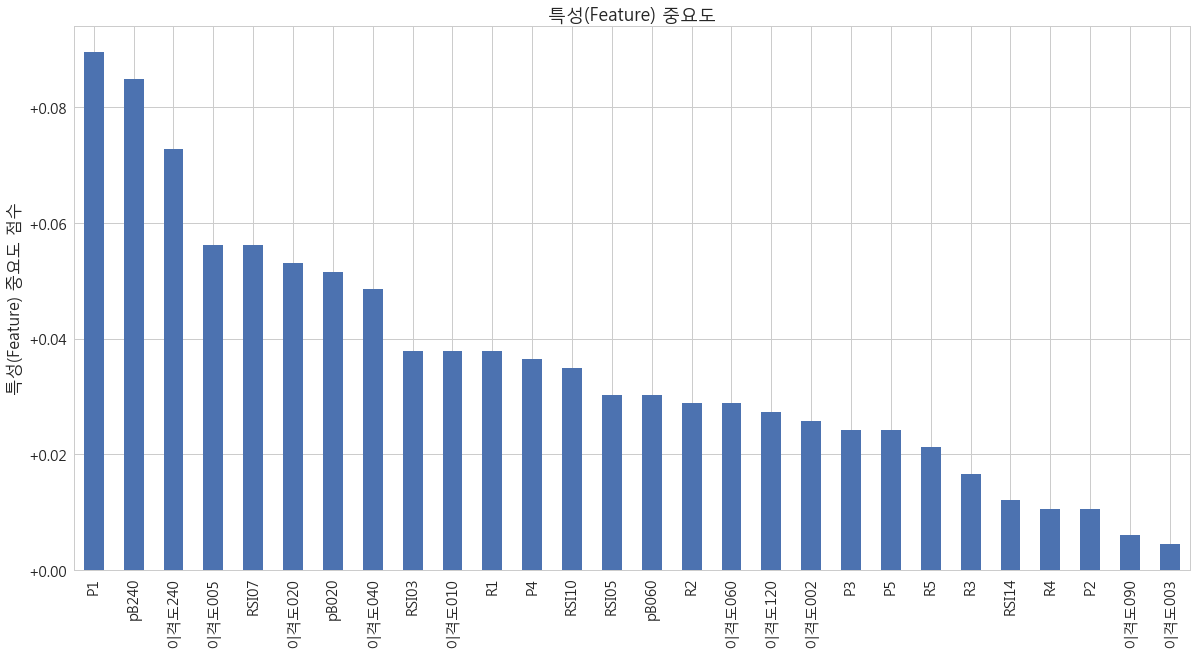

In [15]:
X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

matplotlib.rcParams['figure.figsize'] = [20, 10]
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

In [16]:
param_grid = {
    'max_depth': range(1, 4, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], 
    'n_estimators': range(10, 50, 10),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'colsample_bylevel':[0.8, 1.0]
}

XGBoost_TuningTest(model, X=np.array(X), y=np.array(y), param_grid=param_grid)

Best: -0.422286 using {'colsample_bytree': 1.0, 'n_estimators': 40, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'max_depth': 3, 'learning_rate': 0.1}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

모델 보고서
정확도(Accuracy) : 0.8056
AUC 점수 (Train): 0.893991
교차검증(CV) 점수 : 평균 - 0.8175579 | 표준편차 - 0.07298909 | 최소값 - 0.6864067 | 최대값 - 0.8798085


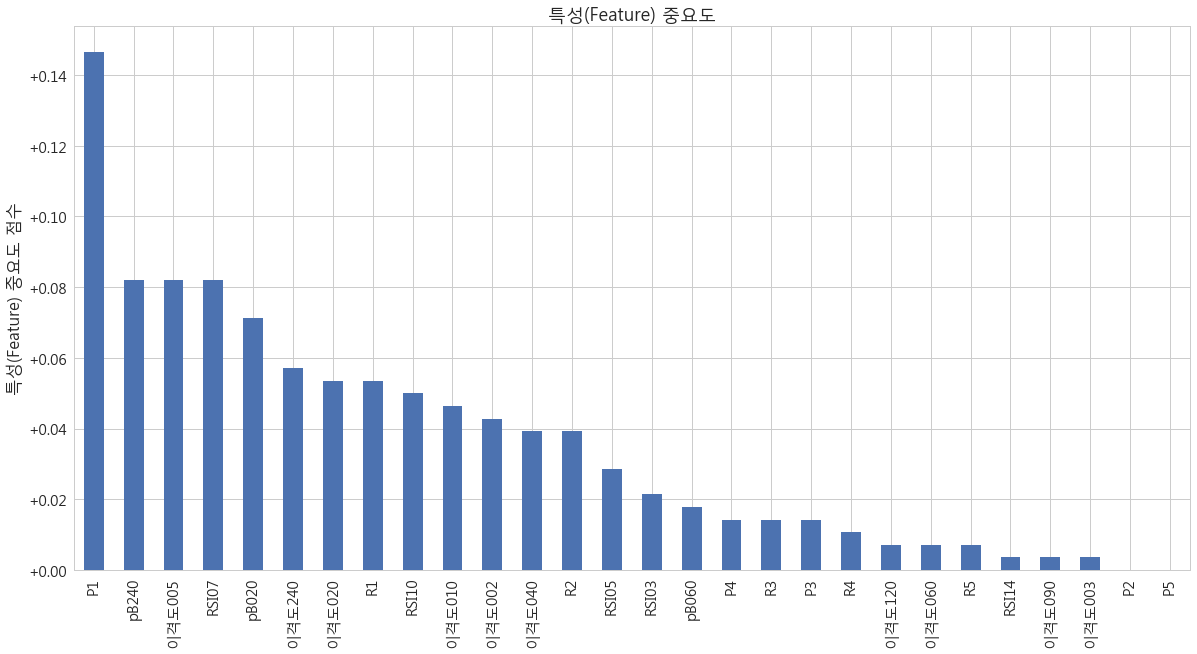

In [17]:
tuned_params = {'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40, 'subsample': 1.0, 'random_state': 0}
model = XGBClassifier(**tuned_params)

matplotlib.rcParams['figure.figsize'] = [20, 10]
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)